## Super resolution

In [21]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [22]:
path = untar_data(URLs.PETS)

In [23]:
path_hr = path/'images'
path_mr = path/'small-256'
path_lr = path/'small-96'


In [24]:
il = ImageList.from_folder(path_hr)

In [25]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)
    

In [27]:
sets = [(path_lr, 96), (path_mr, 256)]

for p, size in sets:
    if p.exists():
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

resizing to 96 into /home/jupyter/.fastai/data/oxford-iiit-pet/small-96


resizing to 256 into /home/jupyter/.fastai/data/oxford-iiit-pet/small-256


In [28]:
bs, size = 32, 128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [29]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [30]:
data = get_data(bs, size)

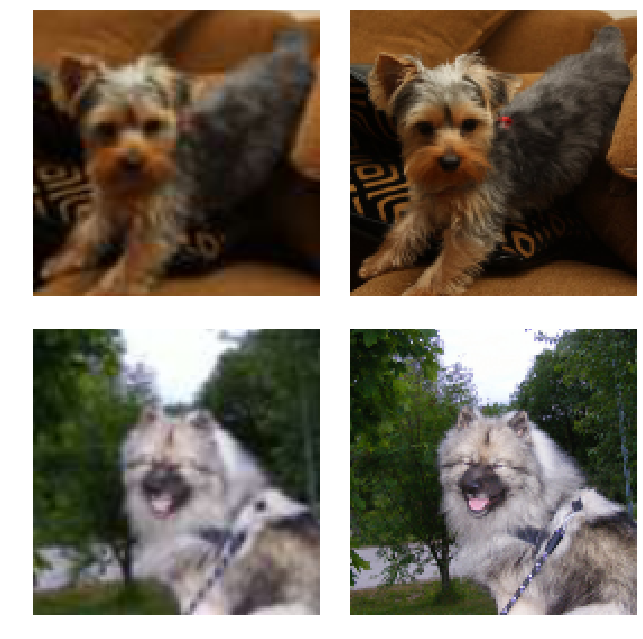

In [31]:
data.show_batch(ds_type=DatasetType.Valid, rows=7, figsize=(9, 9))

### Feature loss

In [32]:
t = data.valid_ds[0][1].data
t = torch.stack([t, t])

In [33]:
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1, 2)) / (c*h*w)

In [34]:
gram_matrix(t)

tensor([[[0.0461, 0.0322, 0.0193],
         [0.0322, 0.0233, 0.0148],
         [0.0193, 0.0148, 0.0103]],

        [[0.0461, 0.0322, 0.0193],
         [0.0322, 0.0233, 0.0148],
         [0.0193, 0.0148, 0.0103]]])

In [35]:
base_loss = F.l1_loss

In [36]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [37]:
blocks = [i-1 for i,o, in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [38]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel', ] + [f'feat_{i}' for i in range(len(layer_ids))
                                          ] + [f'gram_{i}' for i in range(len(layer_ids))]
    
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input, target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()
                 
                

In [39]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5, 15, 2])

### Train

In [40]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, 
                    blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


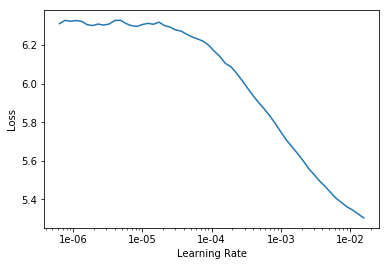

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
lr = 1e-3

In [43]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=7, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.897557,3.760878,0.153298,0.228305,0.313832,0.224340,0.558703,1.210136,1.072263,01:08
1,3.754524,3.598782,0.137979,0.223929,0.305165,0.216424,0.521973,1.158859,1.034452,01:07
2,3.709643,3.489972,0.134739,0.222383,0.297992,0.208926,0.503058,1.120191,1.002683,01:07
3,3.633356,3.422595,0.134908,0.221025,0.293338,0.204438,0.488526,1.096950,0.983410,01:07
4,3.574890,3.432300,0.161428,0.220639,0.293169,0.202327,0.489938,1.094363,0.970435,01:07
5,3.516113,3.378077,0.140239,0.219805,0.290436,0.200603,0.484156,1.079680,0.963158,01:08
6,3.503093,3.333115,0.135918,0.216680,0.285990,0.197280,0.478991,1.067936,0.950319,01:08
7,3.467120,3.266543,0.139729,0.216264,0.283046,0.193175,0.457748,1.047121,0.929461,01:08
8,3.443092,3.218179,0.131583,0.214605,0.280559,0.191967,0.440506,1.034126,0.924832,01:07
9,3.348485,3.139835,0.130311,0.212808,0.275581,0.186387,0.427220,1.012485,0.895044,01:08


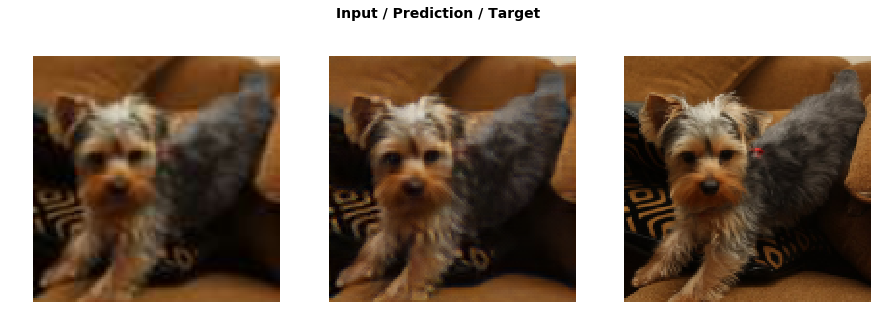

In [44]:
do_fit('1a', slice(lr*10))

In [45]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.318005,3.135252,0.129942,0.212737,0.275381,0.186218,0.426072,1.011577,0.893324,01:10
1,3.329103,3.130149,0.130023,0.212641,0.275134,0.186149,0.423624,1.009760,0.892818,01:10
2,3.305946,3.126304,0.129660,0.212339,0.274585,0.185615,0.424556,1.009080,0.890469,01:10
3,3.310118,3.124079,0.129885,0.212434,0.274483,0.185774,0.421988,1.007228,0.892287,01:10
4,3.303962,3.113867,0.130399,0.212602,0.274367,0.185246,0.418504,1.004576,0.888173,01:10
5,3.278461,3.101827,0.129020,0.211292,0.272983,0.184290,0.418433,1.000893,0.884915,01:10
6,3.294361,3.104686,0.129087,0.211040,0.272803,0.184608,0.420938,1.000976,0.885235,01:11
7,3.280829,3.098499,0.129712,0.210889,0.272212,0.183911,0.419572,0.999624,0.882578,01:10
8,3.285068,3.101367,0.129477,0.210646,0.271916,0.183690,0.422570,1.001057,0.882011,01:10
9,3.254078,3.074623,0.129548,0.210863,0.271440,0.182613,0.411646,0.992467,0.876047,01:10


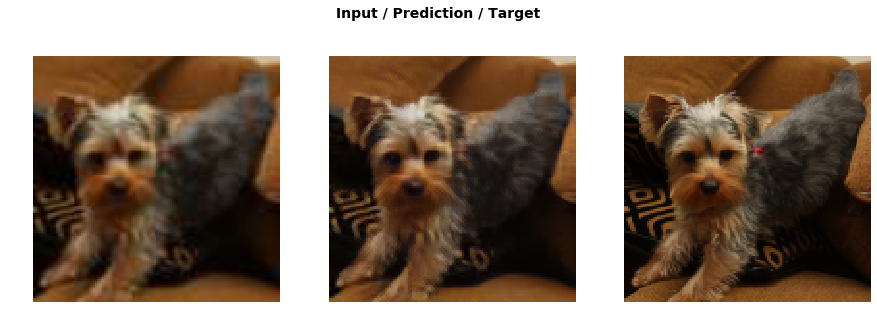

In [46]:
do_fit('1b', slice(1e-5, lr))

In [47]:
data = get_data(12, size*2)

In [48]:
learn.data = data
learn.freeze()
gc.collect()

18541

In [49]:
learn.load('1b')

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/small-96;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, pad

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.238700,2.179053,0.157564,0.255347,0.291995,0.154008,0.375462,0.576072,0.368605,04:44
1,2.209266,2.153051,0.158477,0.256853,0.291517,0.153394,0.360372,0.567174,0.365264,04:30
2,2.184377,2.139515,0.158776,0.256883,0.290018,0.152394,0.354608,0.564160,0.362677,04:30
3,2.156554,2.122251,0.160613,0.256718,0.288052,0.151473,0.347886,0.558266,0.359242,04:29
4,2.154891,2.108175,0.159234,0.255906,0.286052,0.150223,0.344612,0.555674,0.356475,04:29
5,2.141369,2.105414,0.161347,0.255774,0.286311,0.150158,0.341069,0.555684,0.355071,04:30
6,2.132652,2.085132,0.159923,0.254968,0.283984,0.149322,0.333969,0.550102,0.352865,04:30
7,2.105636,2.082134,0.159397,0.254154,0.282938,0.147725,0.337479,0.549813,0.350628,04:30
8,2.107533,2.071928,0.161581,0.254684,0.282512,0.147249,0.331420,0.546297,0.348185,04:30
9,2.070365,2.046496,0.158220,0.252223,0.280366,0.145898,0.325569,0.539316,0.344904,04:30


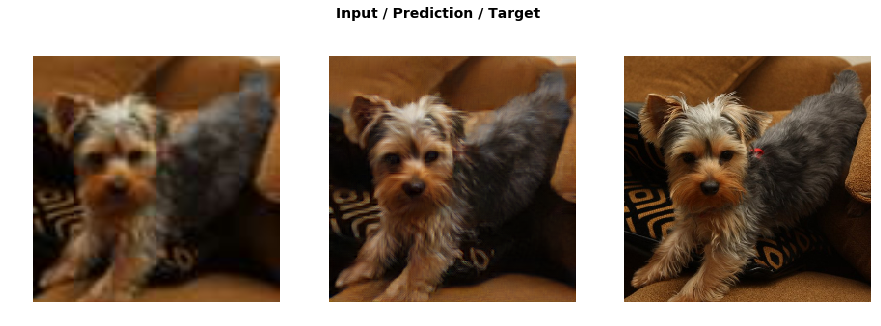

In [50]:
do_fit('2a')

In [51]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.072252,2.045485,0.158899,0.252674,0.280518,0.146006,0.324326,0.538104,0.344958,04:39
1,2.072089,2.043388,0.158298,0.252494,0.280015,0.145598,0.324864,0.537772,0.344346,04:38
2,2.065992,2.041244,0.159229,0.252819,0.280596,0.145798,0.321933,0.536571,0.344299,04:38
3,2.065789,2.041480,0.159384,0.252575,0.279907,0.145667,0.322990,0.536871,0.344087,04:39
4,2.059264,2.036213,0.158550,0.252434,0.279782,0.145250,0.322006,0.535224,0.342969,04:39
5,2.066883,2.035834,0.158950,0.252368,0.279738,0.145302,0.321306,0.535127,0.343042,04:39
6,2.053836,2.032351,0.158340,0.252003,0.279310,0.144904,0.320982,0.534300,0.342512,04:39
7,2.065582,2.030761,0.158466,0.251981,0.279285,0.144843,0.320374,0.533696,0.342116,04:39
8,2.057737,2.030383,0.158277,0.251871,0.279483,0.144884,0.320234,0.533531,0.342103,04:39
9,2.038563,2.031104,0.158703,0.252154,0.279374,0.144913,0.320241,0.533602,0.342115,04:39


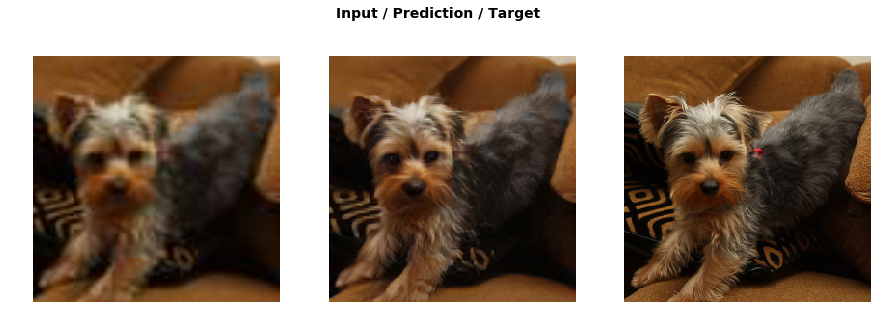

In [52]:
do_fit('2b', slice(1e-6, 1e-4), pct_start=0.3)

### Test

In [53]:
learn = None
gc.collect();

In [54]:
256/320*1024

819.2

In [55]:
256/320*1600

1280.0

In [56]:
free = gpu_mem_get_free_no_cache()

if free > 8000: size=(1280, 1600)
else:           size=( 820, 1024)
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(1280, 1600), have 11400MB of GPU RAM free


In [58]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [63]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_random_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transform(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

AttributeError: 'ImageImageList' object has no attribute 'split_by_random_pct'

In [ ]:
learn.load('2b');

In [ ]:
learn.data = data_mr

In [ ]:
fn = data_mr.valid_ds.x.items[0]; fn

In [ ]:
img = open_image(fn); image.shape

In [60]:
p, img_hr, b = learn.predict(img)

NameError: name 'img' is not defined

In [61]:
show_image(img, figsize=(18, 15), interpolation='nearest');

NameError: name 'img' is not defined

In [62]:
Image(img_hr).show(figsize=(18, 15))

NameError: name 'img_hr' is not defined